<a href="https://colab.research.google.com/github/iam-Dylan/automated-essay-scoring/blob/meo/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
# nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. EDA tổng quát

In [5]:
test  = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test.csv")
train = pd.read_csv('drive/MyDrive/Colab Notebooks/data/train.csv')
test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [6]:
data = train.copy()


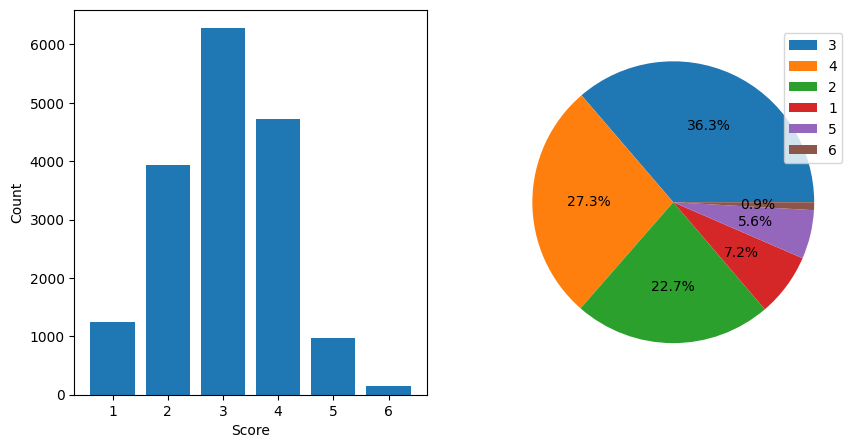

In [43]:
# ti le phan bo diem
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(data['score'].unique(), data['score'].value_counts())
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Count')

ax[1].pie(data['score'].value_counts(), autopct='%1.1f%%')
ax[1].legend(labels = data['score'].unique(), loc = 'upper right')
plt.show()

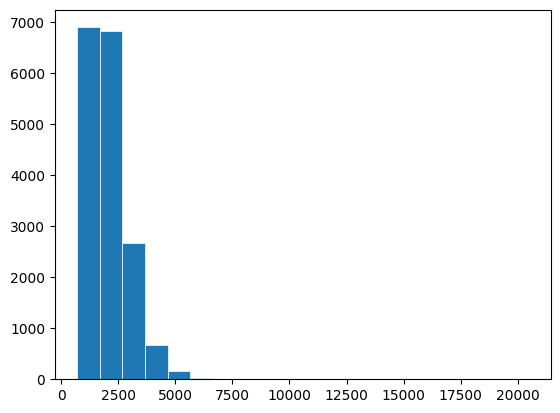

In [9]:
# do dai essay
data['len_text'] = data['full_text'].str.len() ;
plt.hist(data['len_text'], bins=20, edgecolor='w', linewidth=0.5)
# sns.distplot(data['len_text'], hist=False)
plt.show()

# plt.boxplot(data['len_text'])
# plt.show()


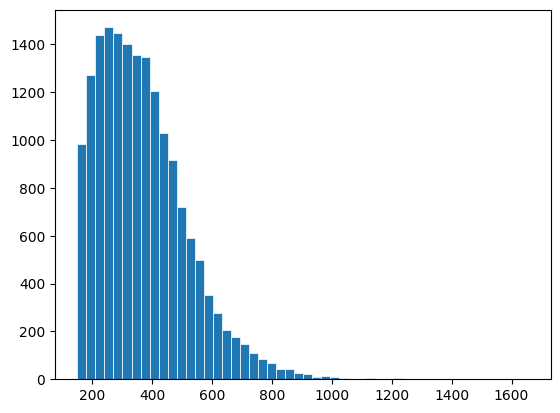

In [11]:
# so tu moi essay
def word_count(df):
    df = df.split()
    return len(df)

data['word_count'] = data['full_text'].agg(word_count)
plt.hist(data['word_count'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()


In [12]:
# trung binh do dai tu trong moi essay
data['mean_word_length'] = data['full_text'].map(lambda text: np.mean([len(word) for word in text.split()]))
data.head(10)

,essay_id,full_text,score,len_text,word_count,mean_word_length
0,000d118,Many people have car where they live. The thin...,3,2677,498,4.369478
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,332,4.018072
2,001ab80,People always wish they had the same technolog...,4,3077,550,4.574545
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,451,4.982262
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,373,4.873995
5,0030e86,If I were to choose between keeping the electo...,4,2374,400,4.890000
6,0033037,The posibilty of a face reconizing computer wo...,2,1031,179,4.754190
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,1992,353,4.569405
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,1870,310,5.003226
9,0040e27,There are many reasons why you should join sea...,3,1521,280,4.417857


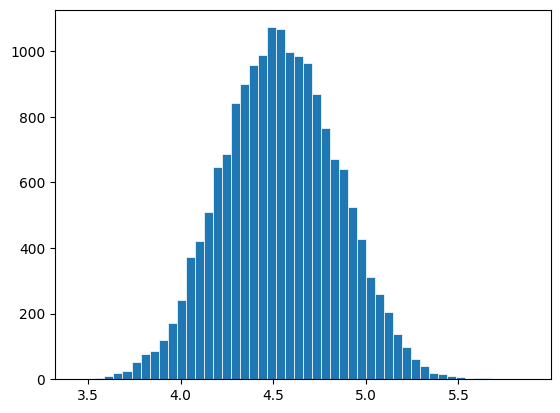

In [13]:
plt.hist(data['mean_word_length'], bins=50,edgecolor='w', linewidth=0.5);
plt.show()

In [14]:
# mean of (length sentence
data['mean_sent_length'] = data['full_text'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))
data.head(10)

,essay_id,full_text,score,len_text,word_count,mean_word_length,mean_sent_length
0,000d118,Many people have car where they live. The thin...,3,2677,498,4.369478,204.692308
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,332,4.018072,78.333333
2,001ab80,People always wish they had the same technolog...,4,3077,550,4.574545,126.750000
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,451,4.982262,133.950000
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,373,4.873995,145.266667
5,0030e86,If I were to choose between keeping the electo...,4,2374,400,4.890000,97.208333
6,0033037,The posibilty of a face reconizing computer wo...,2,1031,179,4.754190,146.142857
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,1992,353,4.569405,74.653846
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,1870,310,5.003226,102.444444
9,0040e27,There are many reasons why you should join sea...,3,1521,280,4.417857,64.956522


In [15]:
def sent_count(df):
    token = sent_tokenize(df, language='english')
    return len(token)

data['sent_count'] = data['full_text'].agg(sent_count)

data['sent_count']

0        13
1        21
2        24
3        20
4        15
         ..
17302     9
17303    26
17304    15
17305    11
17306    11
Name: sent_count, Length: 17307, dtype: int64

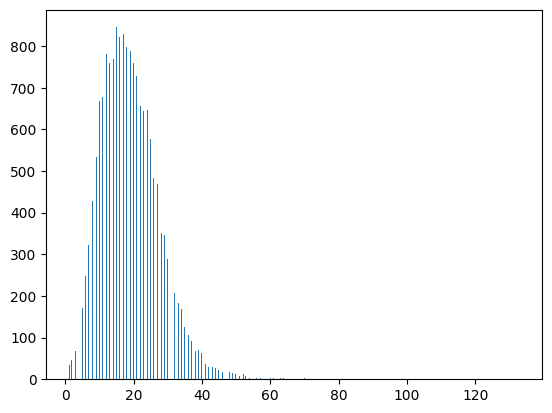

In [16]:
plt.hist(data['sent_count'], bins=500,edgecolor='w', linewidth=0.01)
plt.show()

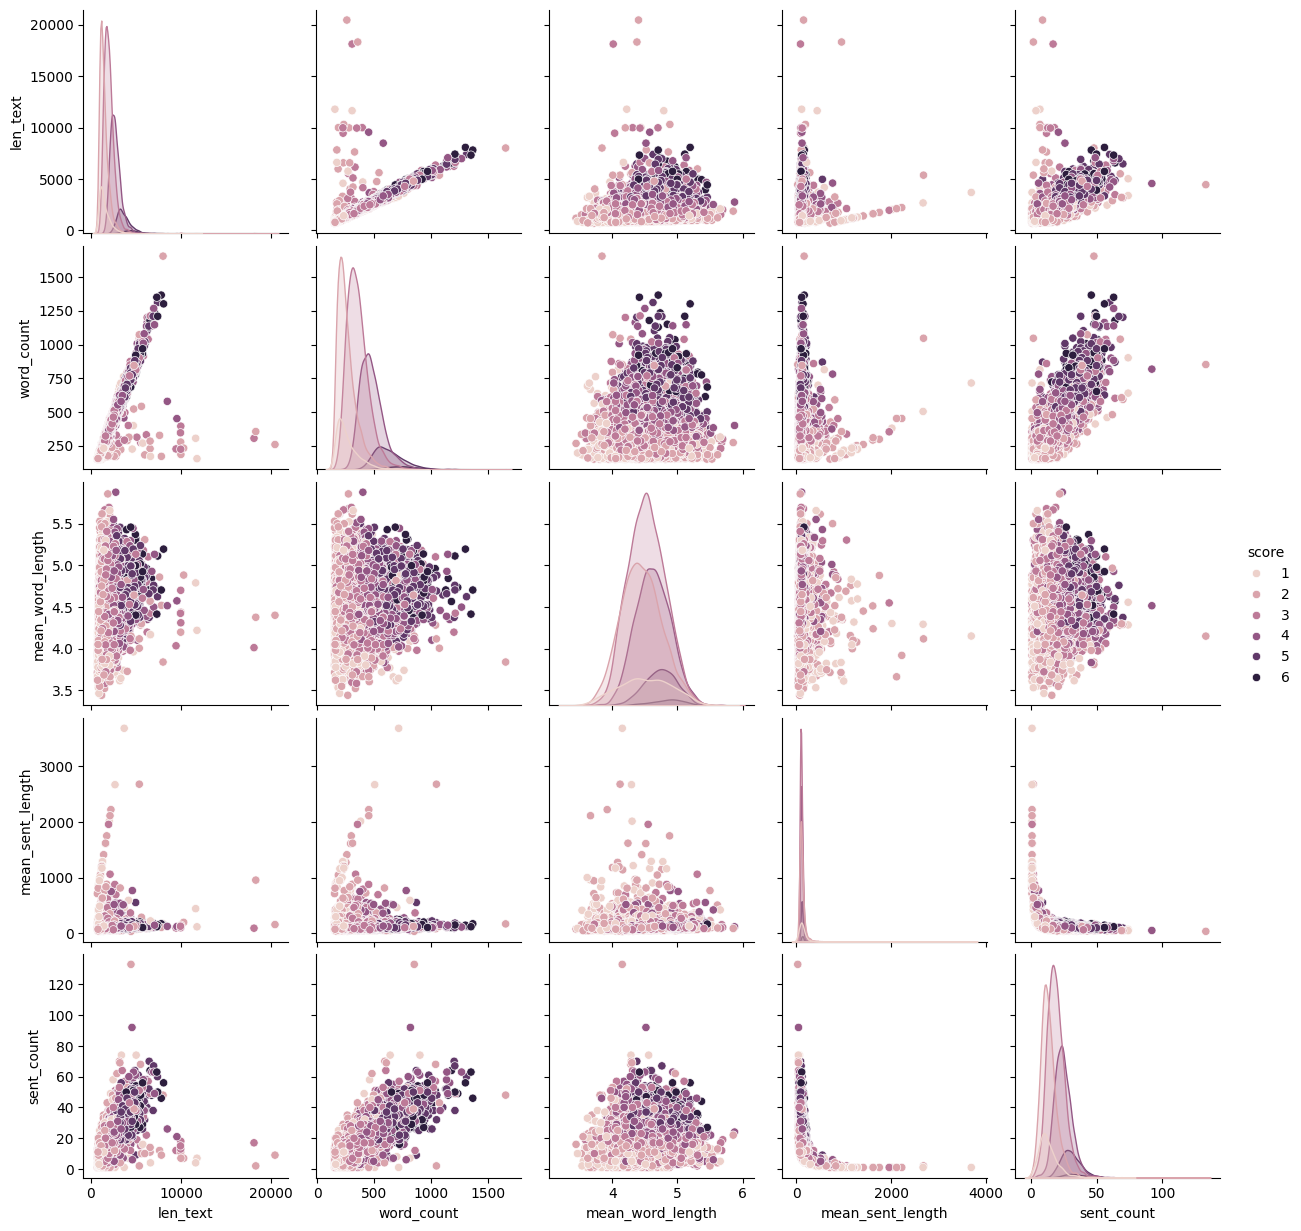

In [17]:
col = ['len_text', 'word_count', 'mean_word_length', 'mean_sent_length','sent_count', 'score']
sns.pairplot(data[col], hue ='score') # hue - label
plt.show()


In [18]:
# data[col].corr()

,len_text,word_count,mean_word_length,mean_sent_length,sent_count,score
len_text,1.000000,0.919812,0.261789,0.037794,0.716987,0.648500
word_count,0.919812,1.000000,0.161977,0.022829,0.788445,0.690035
mean_word_length,0.261789,0.161977,1.000000,0.030563,0.116316,0.247494
mean_sent_length,0.037794,0.022829,0.030563,1.000000,-0.329966,-0.068506
sent_count,0.716987,0.788445,0.116316,-0.329966,1.000000,0.583232
score,0.648500,0.690035,0.247494,-0.068506,0.583232,1.000000


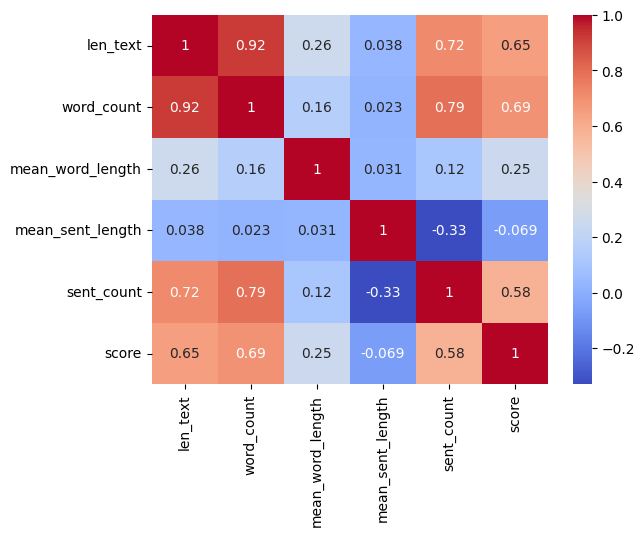

In [19]:
sns.heatmap(data[col].corr(), annot = True, cmap = 'coolwarm')
plt.show()

score - len_text

score - word count

### Kiểm định (?)

### 2. EDA về nội dung

#### Trực quan tần suất các từ bằng wordcloud

In [20]:
# function to plot world cloud:
def plot_wordcloud(df, column, title, stopwords):

    # Define stopwords
    stopwords = stop

    # Define the Wordcloud
    wordcloud = WordCloud(width = 800,
                          height = 800,
                          background_color ='black',
                          min_font_size = 10,
                          stopwords = stopwords).generate(' '.join(df[column]))

    # Plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('Wordcloud: ' + title, fontsize = 20)

    plt.show()



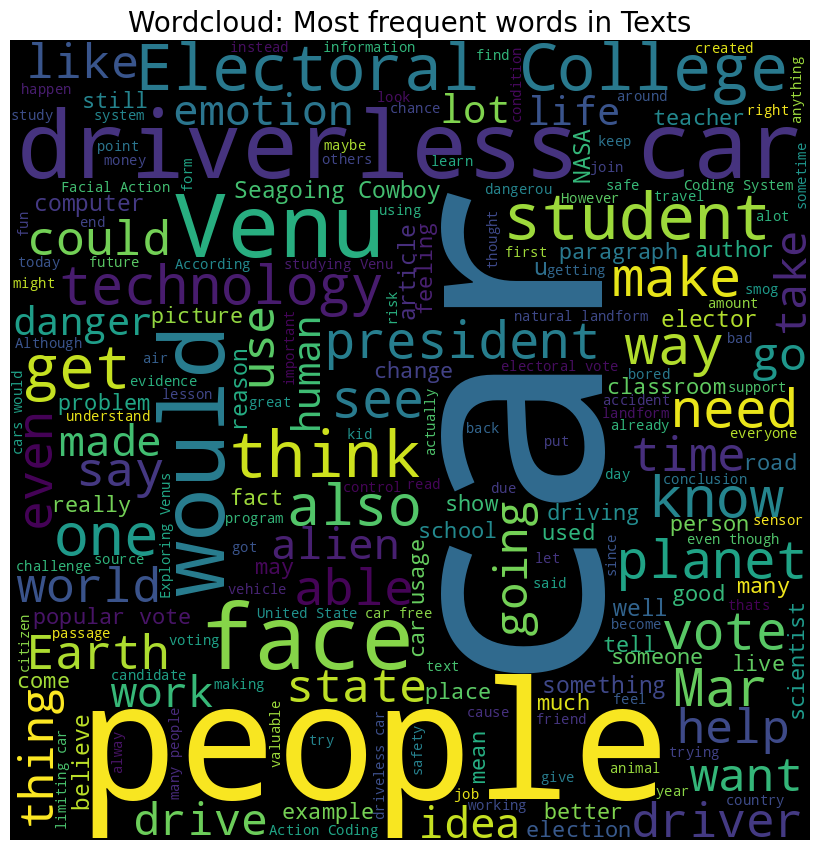

In [21]:
plot_wordcloud(data,column = 'full_text', title = 'Most frequent words in Texts', stopwords = stop)

In [ ]:
# plot_wordcloud(data,column = 'full_text', title = 'Most frequent words in Texts (include stopword)', stopwords = None)

Nhận xét:
- Bằng wordcloud có thể nhận ra một số từ được dùng nhiều ví dụ như : car, people..
- Wordcloud cho ta một cái nhìn tổng thể về tần suất, có thể thấy từ dùng nhiều nhất bởi nó hiển thị to nhất. Tuy nhiên nó chỉ có tác dụng trực quan, không có số liệu rõ ràng để ta phân tích.

&rarr; Ta đến với mô hình N-gram để có cái nhìn rõ hơn về dữ liệu

In [23]:
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'\w+')
# text = "This is my text. It icludes commas, 3434 question marks? and other stuff. Also U.S.."
# tokens = tokenizer.tokenize(text)
# tokens

#### Unigram

In [24]:
#  Unigram - Tan so 1 tu khi chua loc stop word

texts = data['full_text']
vec = CountVectorizer(ngram_range=(1,1)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_10_words = pd.DataFrame(words_freq[:10], columns=['word', 'freq'])
top_10_words

,word,freq
0,the,369541
1,to,207130
2,and,146862
3,of,139419
4,that,115132
5,is,114166
6,in,110010
7,it,105589
8,be,72287
9,are,59923


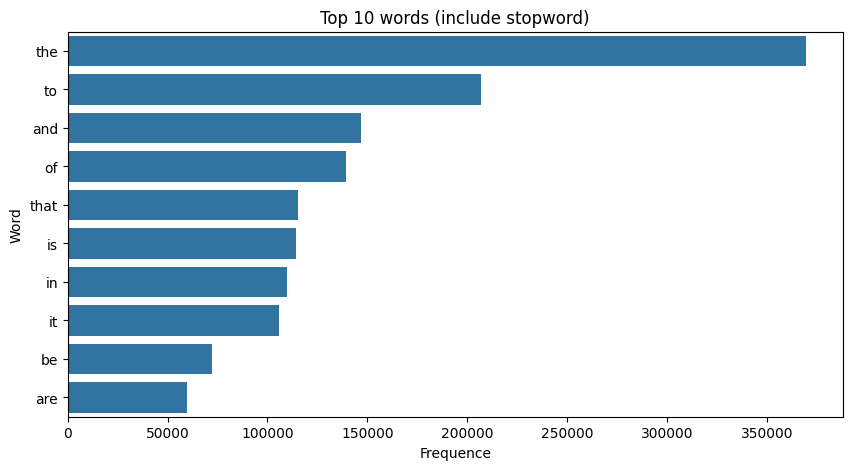

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Word')
plt.title('Top 10 words (include stopword)')
plt.show()


In [26]:
vec_sw = CountVectorizer(ngram_range=(1,1), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_10_words_sw = pd.DataFrame(words_freq_sw[:10], columns=['word', 'freq'])
top_10_words_sw

,word,freq
0,cars,43452
1,car,40219
2,people,39567
3,venus,36728
4,like,25560
5,just,21973
6,driverless,21153
7,face,19676
8,electoral,16625
9,think,16361


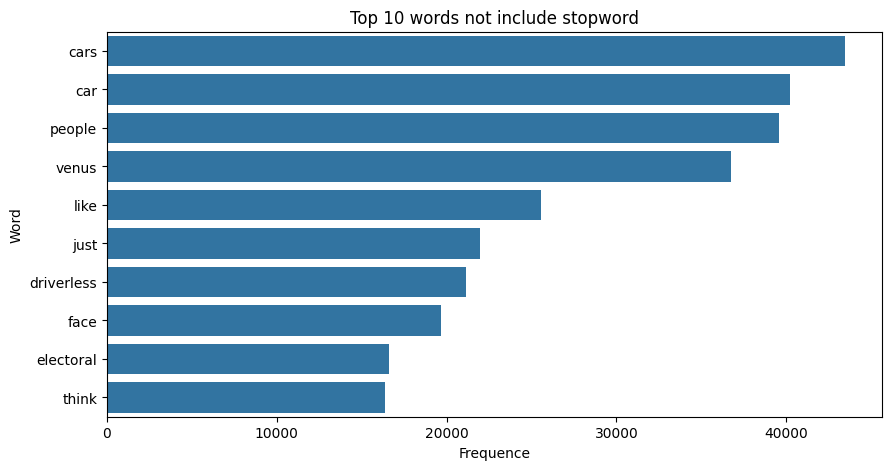

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words_sw, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Word')
plt.title('Top 10 words not include stopword')
plt.show()


Nhận xét:
- Stopword chiếm số lượng khác lớn trong đoạn văn.
- Stopword được dùng nhiều nhất là 'the', lên đến 350000 lần.
- Biểu đồ unigram có sự khác biệt lớn sau khi loại bỏ các stopword.
- Từ biểu đồ bên dưới có thể nhận thấy nội dung essay có lẽ là về car vì các từ được dùng nhiều nhất đều có liên quan đến xe.

#### bigram

In [28]:
vec = CountVectorizer(ngram_range=(2,2)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_10_words2 = pd.DataFrame(words_freq[:10], columns=['word', 'freq'])
top_10_words2

,word,freq
0,in the,31374
1,of the,30533
2,it is,14395
3,to be,14236
4,driverless cars,14197
5,would be,14062
6,on the,14006
7,to the,13606
8,electoral college,12874
9,the electoral,12801


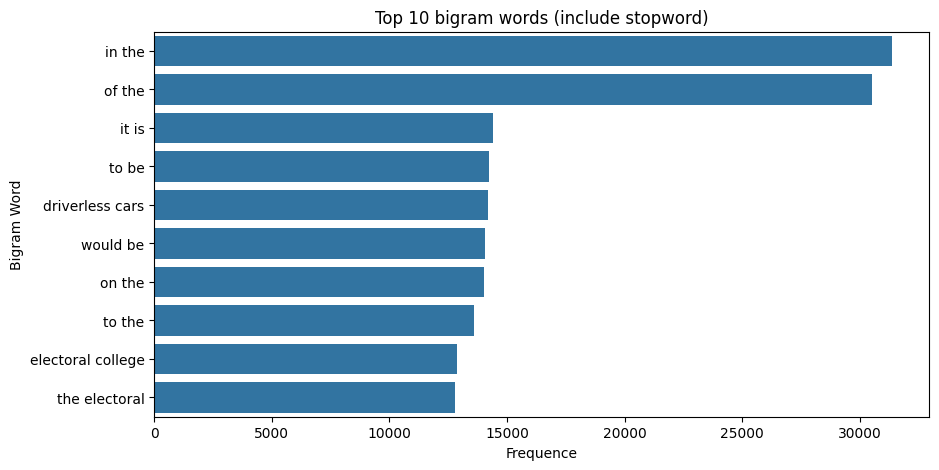

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words2, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Bigram Word')
plt.title('Top 10 bigram words (include stopword)')
plt.show()

In [30]:
vec_sw = CountVectorizer(ngram_range=(2,2), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_10_words_sw2 = pd.DataFrame(words_freq_sw[:10], columns=['word', 'freq'])
# top_10_words_sw

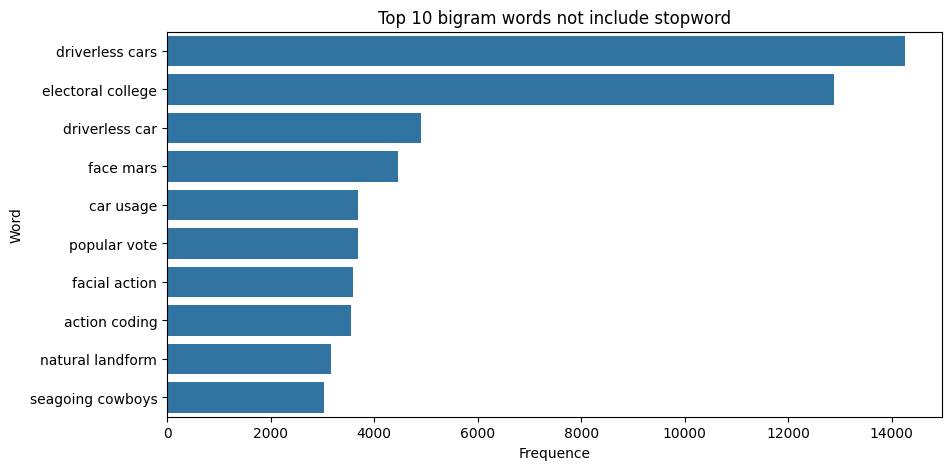

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words_sw2, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Word')
plt.title('Top 10 bigram words not include stopword')
plt.show()

#### Trigram

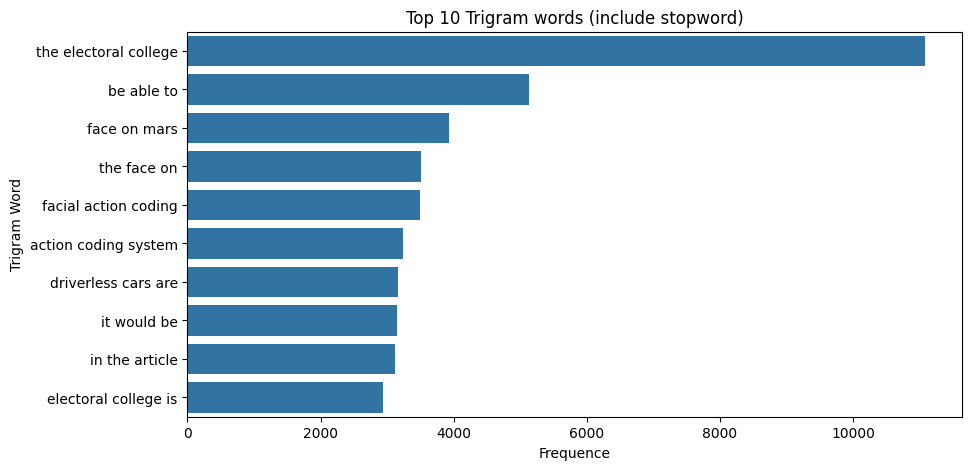

In [32]:
vec = CountVectorizer(ngram_range=(3,3)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_10_words3 = pd.DataFrame(words_freq[:10], columns=['word', 'freq'])


plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words3, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Trigram Word')
plt.title('Top 10 Trigram words (include stopword)')
plt.show()

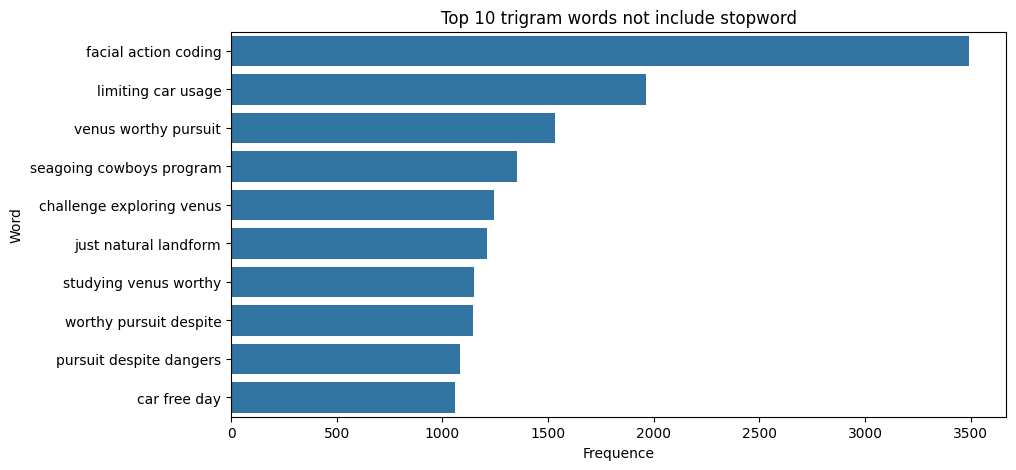

In [33]:
vec_sw = CountVectorizer(ngram_range=(3,3), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_10_words_sw3 = pd.DataFrame(words_freq_sw[:10], columns=['word', 'freq'])

plt.figure(figsize=(10,5))
sns.barplot(x='freq', y ='word', data = top_10_words_sw3, orient='h')
plt.xlabel('Frequence')
plt.ylabel('Word')
plt.title('Top 10 trigram words not include stopword')
plt.show()